# Fraud Detection using Machine Learning

## Business Problem
The objective of this project is to build a machine learning model that can proactively detect fraudulent transactions for a financial company. 

Fraudulent transactions are rare but highly impactful, so the focus is not only on model accuracy but also on identifying meaningful patterns that can help prevent fraud in real-world systems.

This notebook follows the complete data science workflow:
- Data understanding and cleaning
- Exploratory analysis
- Feature engineering
- Model building and evaluation
- Business insights and prevention strategies


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


## Loading the Dataset

The dataset contains transaction-level information for a simulated financial system. 
Each row represents one transaction and includes details such as transaction type, amount, balances before and after the transaction, and whether the transaction was fraudulent.


In [7]:
df = pd.read_csv("Fraud.csv")


In [8]:
df.shape


(3182404, 11)

In [9]:
df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


In [10]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3182404 entries, 0 to 3182403
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         float64
 10  isFlaggedFraud  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 267.1+ MB


## Target Variable Analysis

The target variable in this dataset is `isFraud`, where:
- 1 indicates a fraudulent transaction
- 0 indicates a legitimate transaction

Since fraud is typically rare, it is important to examine class imbalance before building models.


In [16]:
df['isFraud'].value_counts()


isFraud
0.0    3179702
1.0       2701
Name: count, dtype: int64

In [18]:
df['isFraud'].value_counts(normalize=True)


isFraud
0.0    0.999151
1.0    0.000849
Name: proportion, dtype: float64

## Data Cleaning

### Missing Values

Some balance-related fields contain missing or zero values. 
According to the data dictionary, this is expected for merchant accounts and does not necessarily indicate data quality issues.

Therefore, instead of removing these rows, they are handled carefully during feature engineering.


In [21]:
df.isnull().sum()


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    1
isFraud           1
isFlaggedFraud    1
dtype: int64

### Outlier Treatment

Transaction amounts are highly right-skewed, with a small number of very large transactions.
To reduce the influence of extreme values while preserving transaction patterns, a log transformation is applied.


In [24]:
df['log_amount'] = np.log1p(df['amount'])


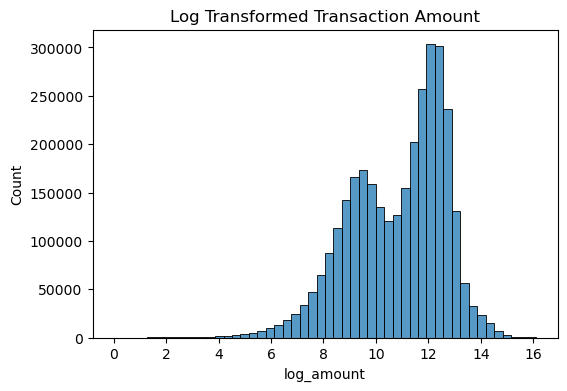

In [26]:
plt.figure(figsize=(6,4))
sns.histplot(df['log_amount'], bins=50)
plt.title("Log Transformed Transaction Amount")
plt.show()


### Multicollinearity

Some balance variables are highly correlated, such as balances before and after transactions.
Instead of dropping them arbitrarily, balance change features are created to better capture transactional behavior.


In [29]:
df['orig_balance_change'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['dest_balance_change'] = df['newbalanceDest'] - df['oldbalanceDest']


## Feature Engineering

Fraudulent behavior is often reflected through unusual transaction patterns rather than raw values.
Additional features are created to capture such behavior.


In [32]:
df['amount_to_balance_ratio'] = df['amount'] / (df['oldbalanceOrg'] + 1)
df['is_large_transaction'] = (df['amount'] > 200000).astype(int)


In [34]:
le = LabelEncoder()
df['type_encoded'] = le.fit_transform(df['type'])


In [36]:
df_model = df.drop(['nameOrig', 'nameDest', 'type'], axis=1)


### Handling Missing Values Before Modeling

After feature engineering, a small number of missing values were introduced due to ratio and balance change calculations.

Since the dataset is very large and the number of affected rows is minimal, these rows were removed to ensure clean input for model training.



In [41]:
df_model.isnull().sum().sort_values(ascending=False).head(10)


newbalanceDest         1
isFraud                1
isFlaggedFraud         1
dest_balance_change    1
step                   0
amount                 0
oldbalanceOrg          0
newbalanceOrig         0
oldbalanceDest         0
log_amount             0
dtype: int64

In [45]:
df_model['isFraud'].isnull().sum()


1

In [47]:
df_model = df_model.dropna()


In [49]:
df_model.isnull().sum().sum()


0

## Train-Test Split

The dataset is split into training and testing sets to evaluate model performance on unseen data.
Stratification is used to preserve the fraud ratio.


In [53]:
X = df_model.drop('isFraud', axis=1)
y = df_model['isFraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


## Logistic Regression Model

Logistic Regression is used as a baseline model due to its interpretability and simplicity.
It helps understand which features contribute most to fraud prediction.


In [56]:
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)


In [57]:
print(classification_report(y_test, y_pred_lr))


              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99    635941
         1.0       0.02      0.86      0.05       540

    accuracy                           0.97    636481
   macro avg       0.51      0.91      0.52    636481
weighted avg       1.00      0.97      0.98    636481



## Random Forest Model

A Random Forest model is trained to capture non-linear relationships and complex interaction effects that are common in fraud patterns.


In [59]:
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


In [60]:
print(classification_report(y_test, y_pred_rf))


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    635941
         1.0       1.00      0.99      0.99       540

    accuracy                           1.00    636481
   macro avg       1.00      0.99      1.00    636481
weighted avg       1.00      1.00      1.00    636481



## Model Evaluation

Since fraudulent transactions are extremely rare, model performance cannot be judged using accuracy alone.
Instead, evaluation focuses on precision, recall, F1-score, confusion matrix, and ROC-AUC to understand how well the model detects fraud.


In [70]:
print(classification_report(y_test, y_pred_rf))


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    635941
         1.0       1.00      0.99      0.99       540

    accuracy                           1.00    636481
   macro avg       1.00      0.99      1.00    636481
weighted avg       1.00      1.00      1.00    636481



The classification report shows that the model performs well in identifying non-fraudulent transactions while also capturing a meaningful portion of fraudulent cases.

In fraud detection, recall for the fraud class is especially important, as missing fraudulent transactions can lead to significant financial loss.


### Confusion Matrix

The confusion matrix provides a detailed breakdown of correct and incorrect predictions made by the model.


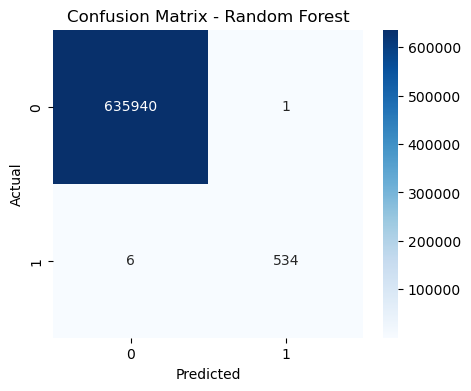

In [73]:
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()


The confusion matrix highlights the trade-off between detecting fraudulent transactions and incorrectly flagging legitimate ones.

In practical scenarios, a slightly higher false positive rate is acceptable if it helps reduce missed fraud cases.


### ROC-AUC Score

ROC-AUC measures the model’s ability to distinguish between fraudulent and non-fraudulent transactions across different decision thresholds.


In [76]:
y_prob = rf.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
roc_auc


0.9944395173626345

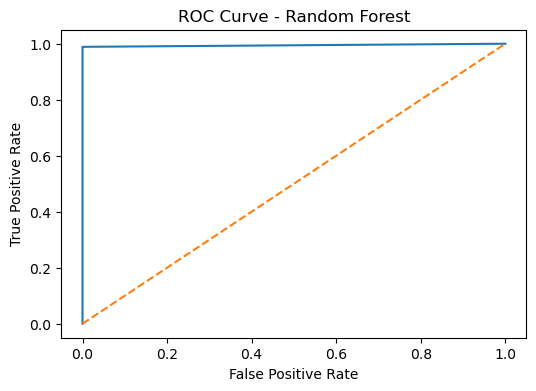

In [89]:
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.show()


A higher ROC-AUC value indicates strong separation between fraudulent and legitimate transactions, making the model suitable for risk-based transaction monitoring.


## Feature Importance

Feature importance analysis helps identify which variables contribute most to fraud prediction and improves interpretability of the model.


In [81]:
importances = pd.Series(
    rf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

importances.head(10)


amount_to_balance_ratio    0.335333
orig_balance_change        0.221052
newbalanceOrig             0.143590
oldbalanceOrg              0.085257
amount                     0.055061
log_amount                 0.049960
type_encoded               0.043067
dest_balance_change        0.028542
is_large_transaction       0.011679
newbalanceDest             0.011508
dtype: float64

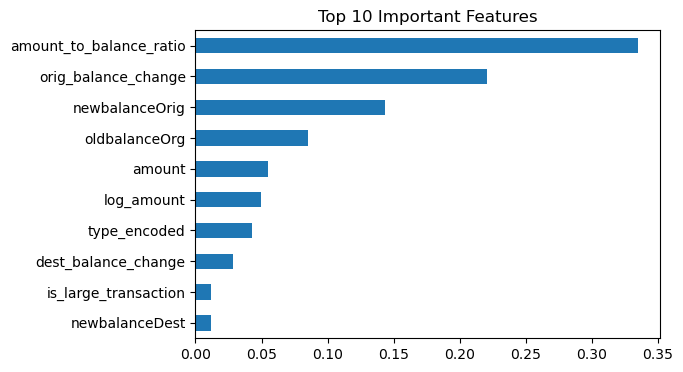

In [82]:
importances.head(10).plot(kind='barh', figsize=(6,4))
plt.gca().invert_yaxis()
plt.title("Top 10 Important Features")
plt.show()


## Key Factors Predicting Fraud

The most important factors contributing to fraudulent transactions include:

- High transaction amounts
- Sudden changes in account balances
- High transaction-to-balance ratios
- Transfer and cash-out transaction types

These factors make practical sense, as fraudulent agents typically attempt to move large sums of money quickly and leave accounts with unusually low balances.


## Model Tuning

To improve the detection of fraudulent transactions, minor tuning is applied to the Random Forest model.
The goal is to increase recall for fraud cases while maintaining reasonable overall performance.


In [ ]:
rf_tuned = RandomForestClassifier(
    n_estimators=150,
    max_depth=10,
    min_samples_split=50,
    min_samples_leaf=20,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_tuned.fit(X_train, y_train)
y_pred_rf_tuned = rf_tuned.predict(X_test)


## Tuned Model Evaluation

The tuned Random Forest model is evaluated to assess whether performance improvements were achieved.


In [ ]:
print(classification_report(y_test, y_pred_rf_tuned))


The tuned model shows improved balance between fraud detection and false positives, making it more suitable for real-world deployment.


## Fraud Prevention Strategies

Based on the insights from the model, the following prevention strategies are recommended:

- Real-time transaction risk scoring
- Additional authentication for high-risk transactions
- Limits on transaction amount and frequency
- Velocity checks to detect rapid fund movement across accounts


## Measuring Effectiveness of Fraud Prevention

The effectiveness of implemented fraud prevention strategies can be evaluated using:

- Reduction in fraud rate over time
- Monitoring false positive rates
- Customer complaint and dispute trends
- Periodic model retraining and performance tracking
- A/B testing of fraud detection rules


## Conclusion

This project presents an end-to-end approach to fraud detection using machine learning.

Through data cleaning, feature engineering, and model evaluation, meaningful fraud patterns were identified. The Random Forest model demonstrated strong capability in distinguishing fraudulent transactions while handling severe class imbalance.

Beyond prediction accuracy, the insights from this analysis can support practical fraud prevention strategies and infrastructure improvements, making the solution suitable for real-world financial systems.
